In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from utils.acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model

from utils.acdc_dataset import *
from utils.training import *
from utils.vqVAE_EMA import *



## Preparing Dataset 

In [2]:
L = 128 # image size L=W
BATCH_SIZE = 16

In [3]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")



#### Segmentation Dataset

In [4]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)



## Prepairing the model

In [5]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 
downsampling_factor = 4

In [6]:
# ACDC_VQVAE = VQVAE(in_channels, D, K, downsampling_factor)
ACDC_VQVAE_EMA = VQVAE(in_channels, D, K, downsampling_factor)


## Training the Model

In [7]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



True
cuda:0


In [20]:
### Learning parameters

model = ACDC_VQVAE_EMA.to(device)

lr = 5e-4
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'saved_models_EMA/vqvae_300_bestmodel.pth'

In [21]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

In [11]:

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, indices, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, indices, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += commit_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model_with_mse(model, TestLoader, device)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

100%|██████████| 119/119 [00:06<00:00, 17.57batch/s, loss=0.0136]


Epoch 0: Train Loss: 0.0258


100%|██████████| 119/119 [00:05<00:00, 20.00batch/s, loss=0.014] 


Epoch 1: Train Loss: 0.0129


100%|██████████| 119/119 [00:05<00:00, 20.69batch/s, loss=0.012]  


Epoch 2: Train Loss: 0.0118


100%|██████████| 119/119 [00:05<00:00, 21.02batch/s, loss=0.0117] 


Epoch 3: Train Loss: 0.0108


100%|██████████| 119/119 [00:08<00:00, 14.36batch/s, loss=0.00952]


Epoch 4: Train Loss: 0.0099


100%|██████████| 119/119 [00:05<00:00, 21.46batch/s, loss=0.00873]


Epoch 5: Train Loss: 0.0090


100%|██████████| 119/119 [00:05<00:00, 21.65batch/s, loss=0.00631]


Epoch 6: Train Loss: 0.0082


100%|██████████| 119/119 [00:05<00:00, 20.76batch/s, loss=0.00749]


Epoch 7: Train Loss: 0.0075


100%|██████████| 119/119 [00:05<00:00, 21.44batch/s, loss=0.00628]


Epoch 8: Train Loss: 0.0069


100%|██████████| 119/119 [00:05<00:00, 21.63batch/s, loss=0.0056] 


Epoch 9: Train Loss: 0.0066


100%|██████████| 119/119 [00:05<00:00, 20.86batch/s, loss=0.00682]


Epoch 10: Train Loss: 0.0059


100%|██████████| 119/119 [00:08<00:00, 14.54batch/s, loss=0.00483]


Epoch 11: Train Loss: 0.0054


100%|██████████| 119/119 [00:05<00:00, 21.23batch/s, loss=0.00482]


Epoch 12: Train Loss: 0.0051


100%|██████████| 119/119 [00:05<00:00, 21.74batch/s, loss=0.00528]


Epoch 13: Train Loss: 0.0047


100%|██████████| 119/119 [00:05<00:00, 21.67batch/s, loss=0.00451]


Epoch 14: Train Loss: 0.0044


100%|██████████| 119/119 [00:06<00:00, 17.20batch/s, loss=0.0043] 


Epoch 15: Train Loss: 0.0044


100%|██████████| 119/119 [00:06<00:00, 17.06batch/s, loss=0.00351]


Epoch 16: Train Loss: 0.0040


100%|██████████| 119/119 [00:05<00:00, 21.59batch/s, loss=0.00396]


Epoch 17: Train Loss: 0.0039


100%|██████████| 119/119 [00:05<00:00, 20.30batch/s, loss=0.00409]


Epoch 18: Train Loss: 0.0038


100%|██████████| 119/119 [00:05<00:00, 22.11batch/s, loss=0.00347]


Epoch 19: Train Loss: 0.0038


100%|██████████| 119/119 [00:05<00:00, 21.49batch/s, loss=0.00407]


Epoch 20: Train Loss: 0.0035


100%|██████████| 119/119 [00:05<00:00, 22.29batch/s, loss=0.00315]


Epoch 21: Train Loss: 0.0034


100%|██████████| 119/119 [00:05<00:00, 21.03batch/s, loss=0.00332]


Epoch 22: Train Loss: 0.0033


100%|██████████| 119/119 [00:05<00:00, 21.98batch/s, loss=0.00235]


Epoch 23: Train Loss: 0.0031


100%|██████████| 119/119 [00:05<00:00, 21.82batch/s, loss=0.0041] 


Epoch 24: Train Loss: 0.0042


100%|██████████| 119/119 [00:06<00:00, 18.30batch/s, loss=0.00325]


Epoch 25: Train Loss: 0.0029


100%|██████████| 119/119 [00:05<00:00, 20.64batch/s, loss=0.00264]


Epoch 26: Train Loss: 0.0028


100%|██████████| 119/119 [00:07<00:00, 15.83batch/s, loss=0.00264]


Epoch 27: Train Loss: 0.0027


100%|██████████| 119/119 [00:06<00:00, 18.79batch/s, loss=0.00322]


Epoch 28: Train Loss: 0.0026


100%|██████████| 119/119 [00:05<00:00, 22.06batch/s, loss=0.00291]


Epoch 29: Train Loss: 0.0025


100%|██████████| 119/119 [00:06<00:00, 17.60batch/s, loss=0.0027] 


Epoch 30: Train Loss: 0.0025


100%|██████████| 119/119 [00:07<00:00, 16.66batch/s, loss=0.00246]


Epoch 31: Train Loss: 0.0024


100%|██████████| 119/119 [00:07<00:00, 16.38batch/s, loss=0.00258]


Epoch 32: Train Loss: 0.0024


100%|██████████| 119/119 [00:05<00:00, 21.26batch/s, loss=0.00205]


Epoch 33: Train Loss: 0.0023


100%|██████████| 119/119 [00:05<00:00, 22.15batch/s, loss=0.00222]


Epoch 34: Train Loss: 0.0022


100%|██████████| 119/119 [00:05<00:00, 20.09batch/s, loss=0.00215]


Epoch 35: Train Loss: 0.0024


100%|██████████| 119/119 [00:05<00:00, 22.09batch/s, loss=0.00231]


Epoch 36: Train Loss: 0.0022


100%|██████████| 119/119 [00:06<00:00, 18.27batch/s, loss=0.00226]


Epoch 37: Train Loss: 0.0021


100%|██████████| 119/119 [00:05<00:00, 21.64batch/s, loss=0.00221]


Epoch 38: Train Loss: 0.0021


100%|██████████| 119/119 [00:05<00:00, 22.23batch/s, loss=0.00211]


Epoch 39: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 22.08batch/s, loss=0.00201]


Epoch 40: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 21.98batch/s, loss=0.00249]


Epoch 41: Train Loss: 0.0022


100%|██████████| 119/119 [00:07<00:00, 16.69batch/s, loss=0.00171]


Epoch 42: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 21.27batch/s, loss=0.00226]


Epoch 43: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 21.81batch/s, loss=0.00175]


Epoch 44: Train Loss: 0.0018


100%|██████████| 119/119 [00:05<00:00, 21.34batch/s, loss=0.00208]


Epoch 45: Train Loss: 0.0017


100%|██████████| 119/119 [00:06<00:00, 17.91batch/s, loss=0.00157]


Epoch 46: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 20.62batch/s, loss=0.00171]


Epoch 47: Train Loss: 0.0018


100%|██████████| 119/119 [00:05<00:00, 21.58batch/s, loss=0.002]  


Epoch 48: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 21.17batch/s, loss=0.0016] 


Epoch 49: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 21.71batch/s, loss=0.00193]


Epoch 50: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 20.25batch/s, loss=0.00174]


Epoch 51: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 22.13batch/s, loss=0.00148]


Epoch 52: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 20.24batch/s, loss=0.0014] 


Epoch 53: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 22.06batch/s, loss=0.0188]


Epoch 54: Train Loss: 0.0695


100%|██████████| 119/119 [00:06<00:00, 19.29batch/s, loss=0.0132]


Epoch 55: Train Loss: 0.0162


100%|██████████| 119/119 [00:07<00:00, 15.66batch/s, loss=0.0111] 


Epoch 56: Train Loss: 0.0123


100%|██████████| 119/119 [00:05<00:00, 22.06batch/s, loss=0.00785]


Epoch 57: Train Loss: 0.0093


100%|██████████| 119/119 [00:05<00:00, 22.07batch/s, loss=0.00754]


Epoch 58: Train Loss: 0.0071


100%|██████████| 119/119 [00:07<00:00, 16.23batch/s, loss=0.00546]


Epoch 59: Train Loss: 0.0058


100%|██████████| 119/119 [00:05<00:00, 22.15batch/s, loss=0.00486]


Epoch 60: Train Loss: 0.0046


100%|██████████| 119/119 [00:05<00:00, 21.67batch/s, loss=0.00333]


Epoch 61: Train Loss: 0.0041


100%|██████████| 119/119 [00:05<00:00, 19.95batch/s, loss=0.00367]


Epoch 62: Train Loss: 0.0036


100%|██████████| 119/119 [00:05<00:00, 21.90batch/s, loss=0.00332]


Epoch 63: Train Loss: 0.0031


100%|██████████| 119/119 [00:05<00:00, 22.24batch/s, loss=0.00321]


Epoch 64: Train Loss: 0.0029


100%|██████████| 119/119 [00:06<00:00, 18.74batch/s, loss=0.00304]


Epoch 65: Train Loss: 0.0027


100%|██████████| 119/119 [00:08<00:00, 14.66batch/s, loss=0.0028] 


Epoch 66: Train Loss: 0.0025


100%|██████████| 119/119 [00:05<00:00, 22.17batch/s, loss=0.002]  


Epoch 67: Train Loss: 0.0024


100%|██████████| 119/119 [00:05<00:00, 22.08batch/s, loss=0.00275]


Epoch 68: Train Loss: 0.0022


100%|██████████| 119/119 [00:07<00:00, 16.93batch/s, loss=0.0026] 


Epoch 69: Train Loss: 0.0021


100%|██████████| 119/119 [00:05<00:00, 21.83batch/s, loss=0.00208]


Epoch 70: Train Loss: 0.0021


100%|██████████| 119/119 [00:05<00:00, 22.20batch/s, loss=0.00155]


Epoch 71: Train Loss: 0.0020


100%|██████████| 119/119 [00:06<00:00, 19.63batch/s, loss=0.00171]


Epoch 72: Train Loss: 0.0019


100%|██████████| 119/119 [00:06<00:00, 17.09batch/s, loss=0.00207]


Epoch 73: Train Loss: 0.0018


100%|██████████| 119/119 [00:05<00:00, 22.05batch/s, loss=0.0016] 


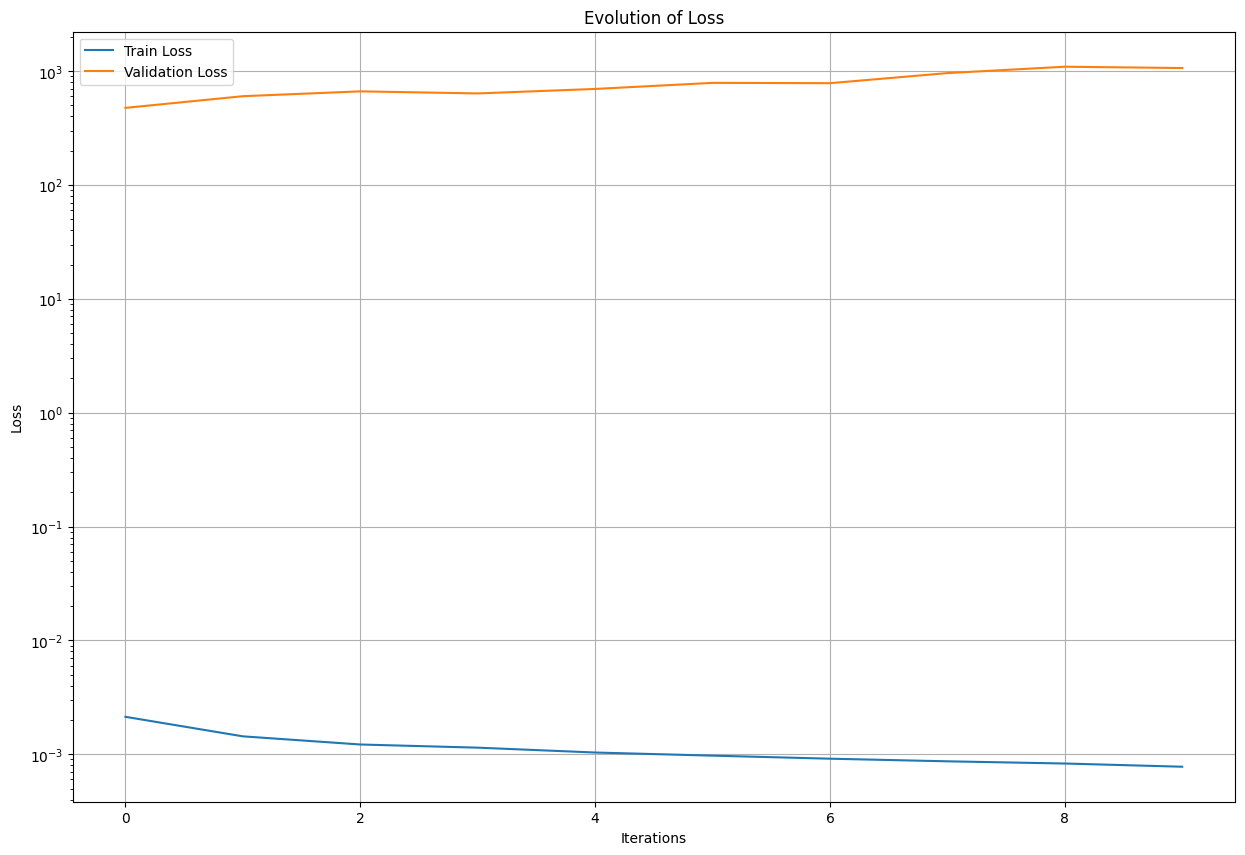

In [12]:
# Plot the training and validation losses
plot_train_val_loss(train_loss_values, val_loss_values)

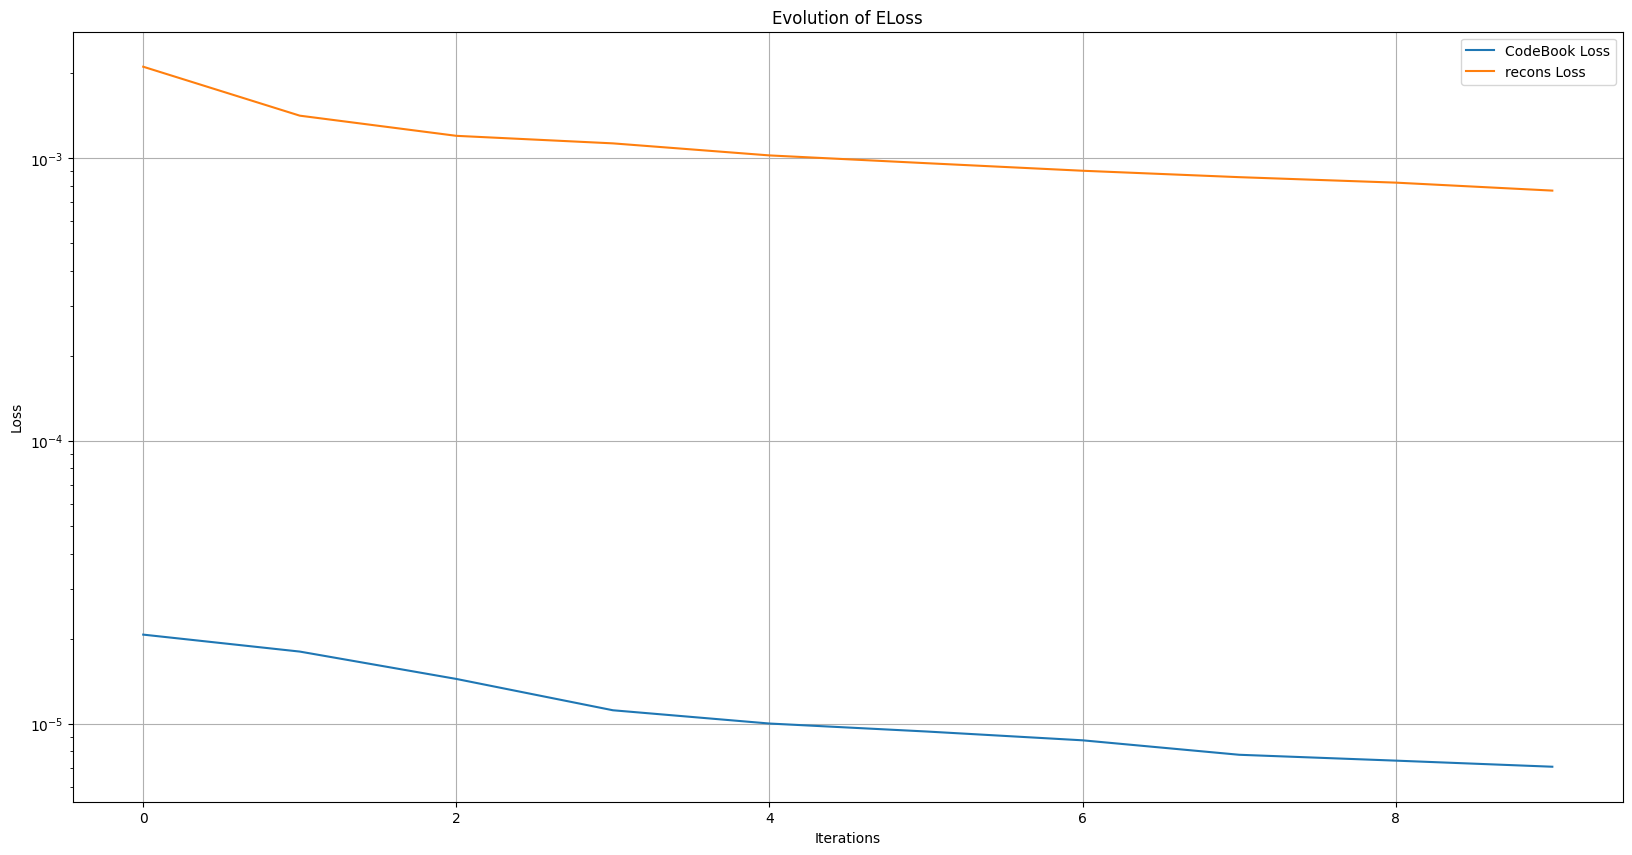

In [13]:

plot_rc_loss(train_loss_values, codebook_loss_values, beta=0.25)


# Test ...

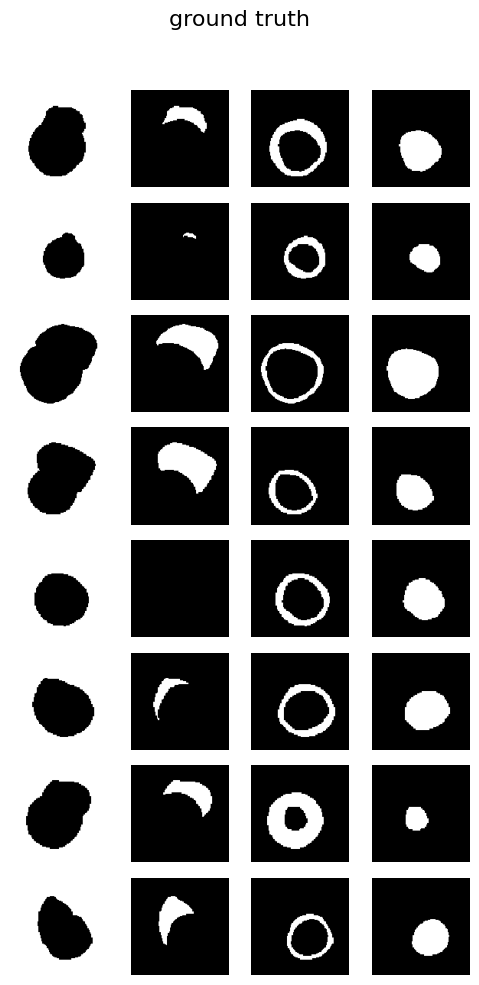

In [14]:
visualize_batch(vis_batch.detach().cpu(), title = "ground truth")

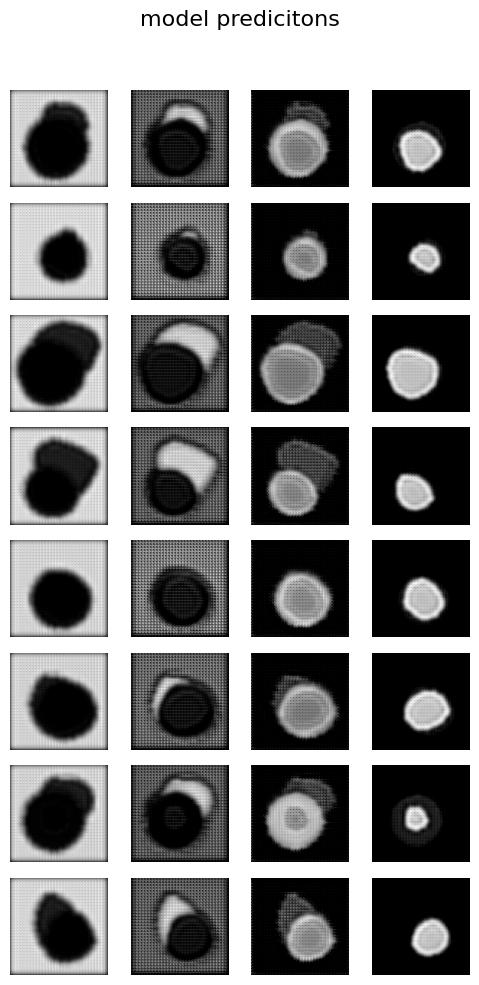

In [15]:
batch_hat = reconstruct_logits(vis_batch, model)

visualize_batch_logits( batch_hat.detach().cpu(), title = "model predicitons")

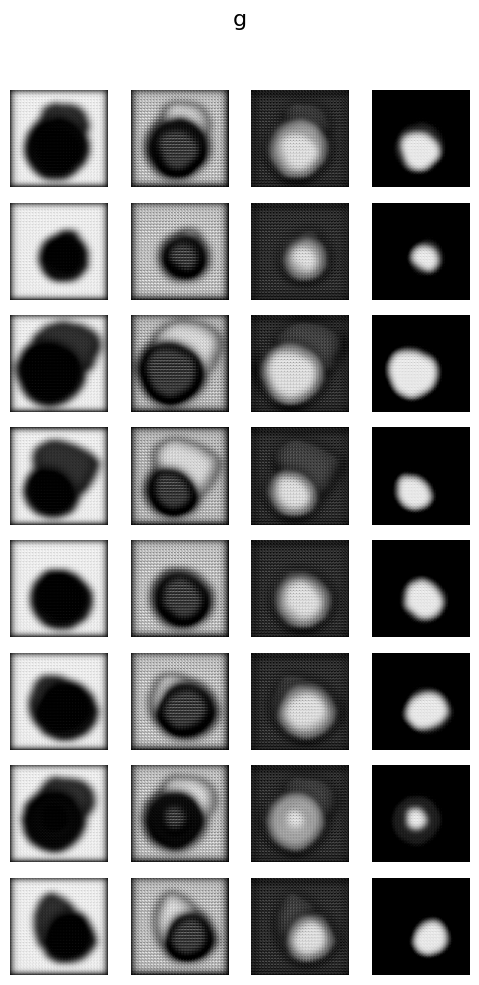

In [19]:
visualize_batch_logits(recons_evolution[0].detach().cpu(), title = "g")